# Loading Data

In [5]:
parquets = "dbfs:/FileStore/tables"
df1 = spark.read.format("parquet").load(parquets)

In [ ]:
df1 = spark.sql("select * from rawdata")

In [6]:
df1.createOrReplaceTempView("dataset")

In [37]:
#df1.createOrReplaceTempView("dataset")
selectedColumns = "row_number() over(order by timedate) as `_c0`,"\
    " speed,linkid `link_id`,timedate `datetime`,hour(timedate) `hour`,"\
    " minute(timedate) `minute`,second(timedate) `second`,weekday(timedate) `weekday`,"\
    " year(timedate) `year`,month(timedate) `month`,day(timedate) `day`,dayofyear(timedate) as `day_of_year`"
df1=spark.sql("select "+selectedColumns+" from dataset where id not in (SELECT ID FROM dataset GROUP BY ID HAVING COUNT(*)<45000)")

In [8]:
df1 = df1.withColumnRenamed("_c0", "ID")

In [9]:
display(df1.select("link_id", "hour", "speed"))

DataFrame[link_id: int, hour: int, speed: double]

In [10]:
data = (df1.groupBy("link_id")
    .pivot("hour")
    .avg("speed") )

display(data)

DataFrame[link_id: int, 0: double, 1: double, 2: double, 3: double, 4: double, 5: double, 6: double, 7: double, 8: double, 9: double, 10: double, 11: double, 12: double, 13: double, 14: double, 15: double, 16: double, 17: double, 18: double, 19: double, 20: double, 21: double, 22: double, 23: double]

In [11]:
data.printSchema()

root
 |-- link_id: integer (nullable = true)
 |-- 0: double (nullable = true)
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: double (nullable = true)
 |-- 6: double (nullable = true)
 |-- 7: double (nullable = true)
 |-- 8: double (nullable = true)
 |-- 9: double (nullable = true)
 |-- 10: double (nullable = true)
 |-- 11: double (nullable = true)
 |-- 12: double (nullable = true)
 |-- 13: double (nullable = true)
 |-- 14: double (nullable = true)
 |-- 15: double (nullable = true)
 |-- 16: double (nullable = true)
 |-- 17: double (nullable = true)
 |-- 18: double (nullable = true)
 |-- 19: double (nullable = true)
 |-- 20: double (nullable = true)
 |-- 21: double (nullable = true)
 |-- 22: double (nullable = true)
 |-- 23: double (nullable = true)



In [12]:
from pyspark.sql.types import StringType
data = data.withColumn("link_id",data.link_id.cast('string'))

# K-Means Clustering

## Creating Vectors for Features

In [14]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [15]:
# Getting a list of all the columns (excluding link_id)
cols = data.drop("link_id").columns

assemble = VectorAssembler( inputCols=cols, outputCol='features' )

assembled_data = assemble.transform(data)

In [16]:
display(assembled_data.select("link_id", "features"))

DataFrame[link_id: string, features: vector]

## Performing Standardization on the dataset

In [17]:
from pyspark.ml.feature import StandardScaler
scale = StandardScaler( inputCol='features', outputCol='standardized' )
data_scale = scale.fit( assembled_data )
data_scale_output = data_scale.transform( assembled_data )

22/04/29 23:05:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [18]:
display( data_scale_output.select( "link_id", "features", "standardized" ) )

DataFrame[link_id: string, features: vector, standardized: vector]

## Performing clustering on the standardized data

In [19]:
# Storing clustering models with k ranging from 2 to 10

d = {}
for i in range(2,10):    
    KMeans_algo = KMeans( featuresCol='standardized', k=i )
    KMeans_fit = KMeans_algo.fit( data_scale_output )
    output = KMeans_fit.transform( data_scale_output )
    d[i] = output

## Evaluating Clusters

In [20]:
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

In [21]:
silhouette_score = []
for i in range(2,10):
    output=d[i]
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score "+str(i)+": ",score)

Silhouette Score 2:  0.7138679813801876


Silhouette Score 3:  0.7089603310279537


Silhouette Score 4:  0.5284049315443347


Silhouette Score 5:  0.4560110754378213


Silhouette Score 6:  0.4230866600919057


Silhouette Score 7:  0.45341480661626676


Silhouette Score 8:  0.448167584435993


Silhouette Score 9:  0.4022875025040021


Text(0, 0.5, 'cost')

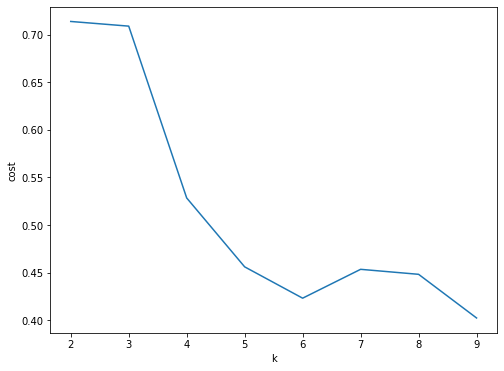

In [22]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

**k=3, appears to work the best**

# Principle Component Analysis

In [23]:
k = 3 # Performing PCA for k = 3

from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=k, inputCol="features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)

22/04/29 23:12:27 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/04/29 23:12:27 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/04/29 23:12:28 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/04/29 23:12:28 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [24]:
# creating a temp dataframe to store the results of k=3 clusters, and renaming link_id column to link, to avoid multiple columns with same name.

temp = d[k].select("prediction", "link_id")
temp = temp.withColumnRenamed("link_id", "link") \
    .withColumnRenamed("prediction", "cluster")

In [25]:
pca_transformed = pca_transformed.join(temp, pca_transformed.link_id == temp.link, 'left_outer')
pca_transformed = pca_transformed.select('link_id','pca','cluster')

In [26]:
# unpacking pca stored as dense vectors in separate columns

from pyspark.ml.functions import vector_to_array

pca_transformed = pca_transformed.withColumn("component", vector_to_array("pca"))
for i in range(0,k):
    pca_transformed = pca_transformed.withColumn("Comp"+str(i), pca_transformed.component[i])

pca_transformed = pca_transformed.select("link_id", "Comp0", "Comp1", "Comp2", "cluster")
display( pca_transformed )

DataFrame[link_id: string, Comp0: double, Comp1: double, Comp2: double, cluster: int]

In [27]:
display(pca_transformed)

DataFrame[link_id: string, Comp0: double, Comp1: double, Comp2: double, cluster: int]

In [28]:
from pyspark.sql.functions import collect_set
print("The Link IDs are clustered as follows:")
display(pca_transformed
        .groupby("cluster")
        .agg(collect_set("link_id").alias('Link ID in the cluster'))
        .sort("cluster")
       )

The Link IDs are clustered as follows:


DataFrame[cluster: int, Link ID in the cluster: array<string>]

---
---

# Visualizing Clusters

## 2D Scatterplot

In [29]:
display(pca_transformed)

DataFrame[link_id: string, Comp0: double, Comp1: double, Comp2: double, cluster: int]

## Back analysis to features and predictions for Map Visualization

In [32]:
pca_transformed.write.csv("pca_transformed_Output")
data_scale_output.select("link_id", "features", "standardized" ).write.json("standardization_Output")

In [33]:
spark.read.schema("LinkId bigint, pca1 double, pca2 double, pca3 double, prediction int").csv("dbfs:/pca_transformed_Output/*.csv").createOrReplaceTempView("cluster")
spark.read.json("dbfs:/standardization_Output/*.json").createOrReplaceTempView("standardize")

In [36]:
from pyspark.sql.functions import split,concat_ws,array_join
join = spark.sql("select distinct id,d.linkid, prediction, s.features.values from cluster c inner join standardize s on s.link_id=c.linkid inner join dataset d on s.link_id=d.linkid order by prediction")

kmeans = join.select(join.id, join.linkid, join.prediction, array_join(join.values,","))
kmeans.coalesce(1).write.csv("kmeans_Output")

## 3D Scatterplot

In [30]:
# creating lists to plot the Components and cluster prediction on a 3D plot

xarray = list(pca_transformed.select('Comp0').toPandas()['Comp0'])
yarray = list(pca_transformed.select('Comp1').toPandas()['Comp1'])
zarray = list(pca_transformed.select('Comp2').toPandas()['Comp2'])
carray = list(pca_transformed.select('cluster').toPandas()['cluster'])

Text(0.5, 0, 'Comp2')

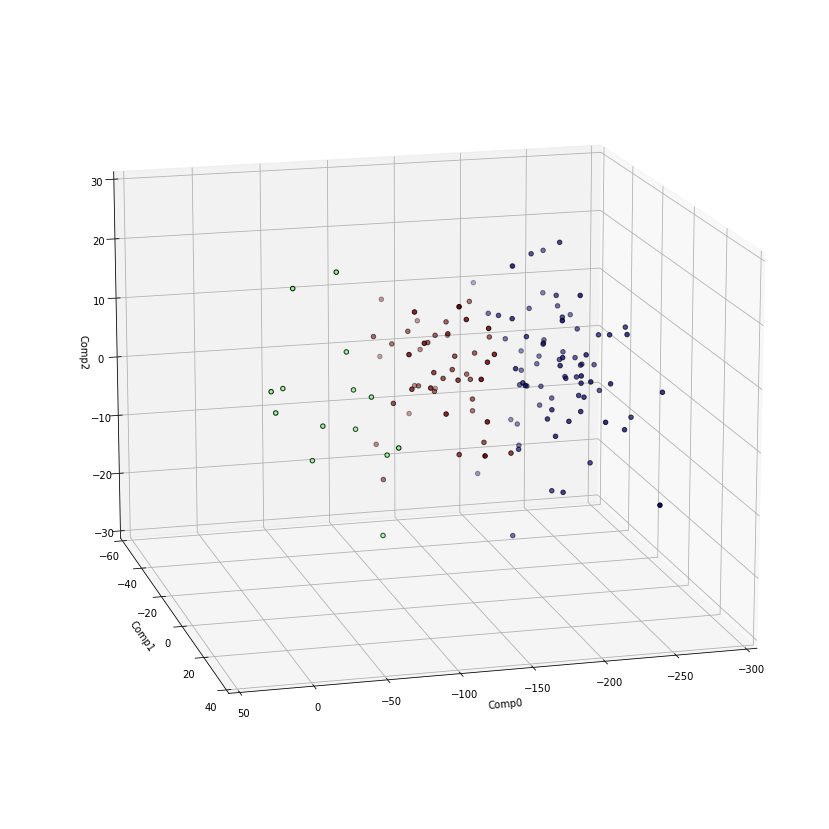

In [31]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(15,15))
ax = plt.axes( projection = "3d" )
plt.style.use('classic')
ax.view_init(15,75)

ax.scatter3D( xs=xarray, ys=yarray, zs=zarray, c=carray)

ax.set_xlabel("Comp0")
ax.set_ylabel("Comp1")
ax.set_zlabel("Comp2")

## Map Projection

In [ ]:
# Get the location for all the link_id's


# Visualize all the link_id's on a map, with clusters as their color.
